<a href="https://colab.research.google.com/github/ladanfarbiz/Students-Performance-Factors---EDA/blob/main/Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import missingno
import plotly.io as pio
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, anderson, norm, uniform

In [2]:
pio.templates.default = "plotly_white"

# 1. Data Overview

In [4]:
df = pd.read_csv('/content/StudentPerformanceFactors.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

In [6]:
df.isnull().sum()

Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64

<Axes: >

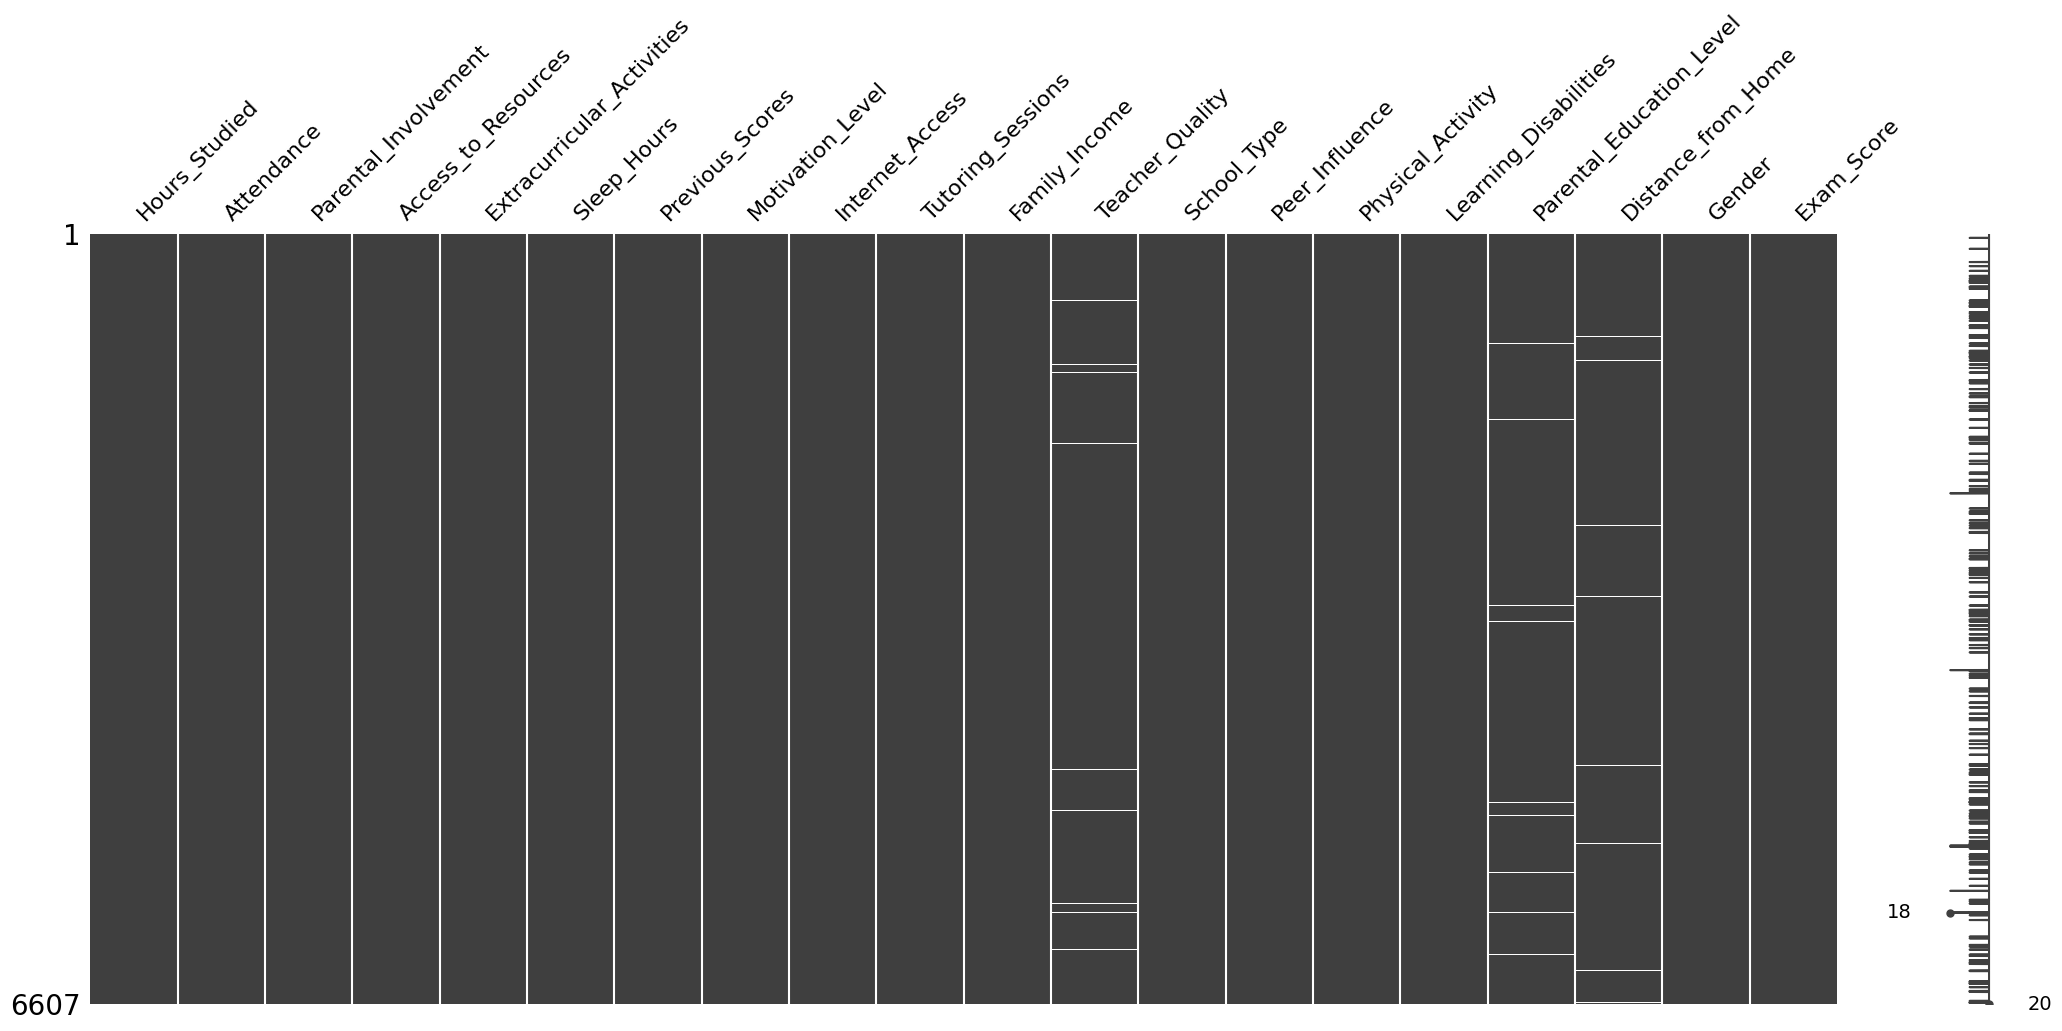

In [7]:
missingno.matrix(df)

In [8]:
df.duplicated().sum()

0

The data does not contain duplicates, however we have to deal with missing values. Fortunately, there is little missing data, approximately 3.46% of the entire dataset. 3 columns contain missing data. We can assume it is safe to remove the entries with null values from the data.

In [9]:
df = df.dropna()

In [10]:
df.isnull().sum()

Hours_Studied                 0
Attendance                    0
Parental_Involvement          0
Access_to_Resources           0
Extracurricular_Activities    0
Sleep_Hours                   0
Previous_Scores               0
Motivation_Level              0
Internet_Access               0
Tutoring_Sessions             0
Family_Income                 0
Teacher_Quality               0
School_Type                   0
Peer_Influence                0
Physical_Activity             0
Learning_Disabilities         0
Parental_Education_Level      0
Distance_from_Home            0
Gender                        0
Exam_Score                    0
dtype: int64

After considering the features from the dataset, couple of them are too abstract to be considered for further analysis and will be dropped from the dataset.

peer influence: not objective enough; it is unclear if this is from the point of view of a teacher, of the family, or of the student
teacher quality: same issue

In [11]:
len(df.columns)

20

In [12]:
chosen_df = df.drop(columns = ['Teacher_Quality', 'Peer_Influence'])

In [13]:
len(chosen_df.columns)

18

Looking at simple descriptive statistics for numerical features.

In [14]:
chosen_df.describe().T

count       mean        std   min   25%   50%   75%    max
Hours_Studied      6378.0  19.977109   5.985460   1.0  16.0  20.0  24.0   44.0
Attendance         6378.0  80.020853  11.550723  60.0  70.0  80.0  90.0  100.0
Sleep_Hours        6378.0   7.034964   1.468033   4.0   6.0   7.0   8.0   10.0
Previous_Scores    6378.0  75.066165  14.400389  50.0  63.0  75.0  88.0  100.0
Tutoring_Sessions  6378.0   1.495296   1.233984   0.0   1.0   1.0   2.0    8.0
Physical_Activity  6378.0   2.972719   1.028926   0.0   2.0   3.0   4.0    6.0
Exam_Score         6378.0  67.252117   3.914217  55.0  65.0  67.0  69.0  101.0

Some exam scores contain unusual values exceeding 100, which can be considered outliers and will be removed to maintain data integrity.

In [15]:
df_cleaned = chosen_df[chosen_df['Exam_Score'] <= 100].copy()
df_cleaned.describe().T

count       mean        std   min   25%   50%   75%    max
Hours_Studied      6377.0  19.976008   5.985283   1.0  16.0  20.0  24.0   44.0
Attendance         6377.0  80.018034  11.549434  60.0  70.0  80.0  90.0  100.0
Sleep_Hours        6377.0   7.035126   1.468091   4.0   6.0   7.0   8.0   10.0
Previous_Scores    6377.0  75.063353  14.399766  50.0  63.0  75.0  88.0  100.0
Tutoring_Sessions  6377.0   1.494747   1.233300   0.0   1.0   1.0   2.0    8.0
Physical_Activity  6377.0   2.972714   1.029006   0.0   2.0   3.0   4.0    6.0
Exam_Score         6377.0  67.246825   3.891637  55.0  65.0  67.0  69.0  100.0

Some columns contain numerical features; however, due to their small range and insufficient variance for the data to be considered continuous, they will be converted into categorical columns.  

The affected columns are:  
- **Sleep_Hours**  
- **Tutoring_Sessions**  
- **Physical_Activity**

Defining numerical, categorical and target columns:

In [16]:
numerical_columns = ['Hours_Studied', 'Attendance', 'Previous_Scores']
categorical_columns = ['Parental_Involvement', 'Access_to_Resources', 'Sleep_Hours', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Tutoring_Sessions', 'Family_Income', 'School_Type', 'Physical_Activity', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']
target = 'Exam_Score'

In [17]:
for col in categorical_columns:
    df_cleaned[col] = df_cleaned[col].astype('category')

# 2. Exploratory Data Analysis
I. Feature distribution
A. Target distribution

In [18]:
fig = px.histogram(df_cleaned, x=target, marginal='box', title=f"Distribution of target column (Exam Score)", text_auto=True)
fig.update_layout(bargap=0.2)

fig.show()

In [19]:
df_cleaned[target].describe().T

count    6377.000000
mean       67.246825
std         3.891637
min        55.000000
25%        65.000000
50%        67.000000
75%        69.000000
max       100.000000
Name: Exam_Score, dtype: float64

In [20]:
a = len(df_cleaned[df_cleaned[target] <= 64]) / len(df_cleaned[target]) * 100
b = len(df_cleaned[df_cleaned[target] >= 70]) / len(df_cleaned[target]) * 100
c = len(df_cleaned[(df_cleaned[target] >= 65) & (df_cleaned[target] <= 69)]) / len(df_cleaned[target]) * 100

print('The bottom', f'{a:.2f}', '% are under 64')
print('The top', f'{b:.2f}', '% are over 70')
print('The middle', f'{c:.2f}', '% are between 65 and 69')

The bottom 21.89 % are under 64
The top 24.78 % are over 70
The middle 53.33 % are between 65 and 69


The lower and upper fences help identify outliers within the dataset. Based on the box plot, the interquartile range (IQR) is calculated as Q3 - Q1 = 69 - 65 = 4, with a median of 67. The previously computed average exam score is approximately 67.2, indicating a right-skewed distribution.

Examining the data, scores above 75 are rare, while no scores fall below 55. Although this is not explicitly stated, the absence of scores below 55 suggests that the minimum possible score may not be zero, but rather somewhere between 40 and 50.

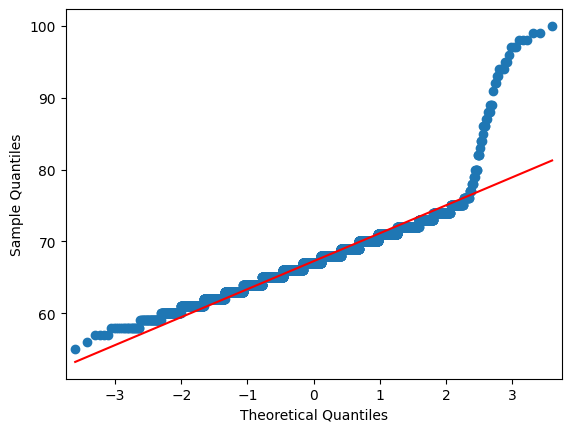

In [21]:
qqplot_data_target = qqplot(df_cleaned[target], line='s').gca().lines

In [22]:
fig = go.Figure()

fig.add_trace({
    'type': 'scatter',
    'x': qqplot_data_target[0].get_xdata(),
    'y': qqplot_data_target[0].get_ydata(),
    'mode': 'markers',
})

fig.add_trace({
    'type': 'scatter',
    'x': qqplot_data_target[1].get_xdata(),
    'y': qqplot_data_target[1].get_ydata(),
    'mode': 'lines',
})


fig['layout'].update({
    'title': 'QQ Plot of Exam Score',
    'xaxis': {
        'title': 'Theoretical Quantities',
        'zeroline': False
    },
    'yaxis': {
        'title': 'Sample Quantities'
    },
    'showlegend': False,
    'width': 800,
    'height': 700,
})

fig.show()


Testing the distribution for normality, we can see that it is not the case. Due to the high number of points to the right, the quantile go further and further away from the normal distribution line.

Numerical **features**

In [23]:
theme_colors = pio.templates["ggplot2"].layout.colorway

for i, col in enumerate(numerical_columns):
    fig = px.histogram(
        df_cleaned,
        x=col,
        marginal='box',
        title=f"Histogram of {col} with Box Plot",
        text_auto=True,
        color_discrete_sequence=[theme_colors[(i + 1) % len(theme_colors)]]
    )
    fig.update_layout(bargap=0.2)
    fig.show()

The features **'Previous_Scores'** and **'Attendance'** display a relatively uniform distribution, suggesting they have minimal impact on the target variable. In contrast, **'Hours_Studied'** appears to follow a normal distribution, which can be further verified using a normal Q-Q plot.

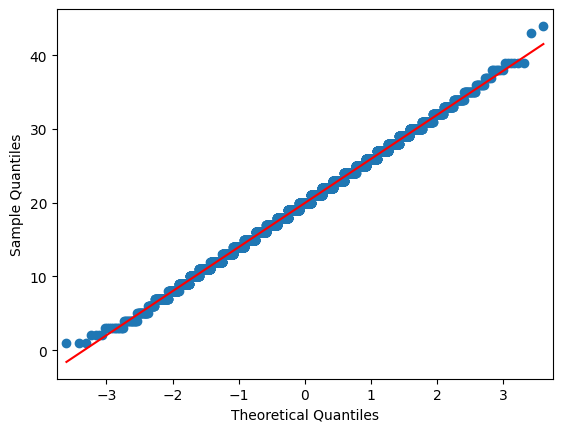

In [24]:
qqplot_data_hs = qqplot(df_cleaned['Hours_Studied'], line='s').gca().lines

In [25]:
fig = go.Figure()

fig.add_trace({
    'type': 'scatter',
    'x': qqplot_data_hs[0].get_xdata(),
    'y': qqplot_data_hs[0].get_ydata(),
    'mode': 'markers',
})

fig.add_trace({
    'type': 'scatter',
    'x': qqplot_data_hs[1].get_xdata(),
    'y': qqplot_data_hs[1].get_ydata(),
    'mode': 'lines',
})


fig['layout'].update({
    'title': 'QQ Plot of Hours_Studied Features',
    'xaxis': {
        'title': 'Theoretical Quantities(Normal)',
        'zeroline': False
    },
    'yaxis': {
        'title': 'Sample Quantities'
    },
    'showlegend': False,
    'width': 800,
    'height': 700,
})

fig.show()


Looking at both the Histogram and the QQ plot we can confidently say that the 'Hours_Studied' feature is normally distributed. However, let's go one step further and use statistical tests to prove normality, namely the Shapiro-Wilk and the Anderson-Darling tests.

In [26]:
stat, p = shapiro(df_cleaned['Hours_Studied'])

alpha = 0.05
msg = 'Sample looks Gaussian (fail to reject H0)' if p > alpha else 'Sample does not look Gaussian (reject H0)'

df_shapiro_results = pd.DataFrame({
    "Statistic": [stat],
    "P-Value": [p],
    "Alpha": [alpha],
    "Interpretation": [msg]
})

print(df_shapiro_results)

   Statistic       P-Value  Alpha                             Interpretation
0   0.997436  6.226081e-09   0.05  Sample does not look Gaussian (reject H0)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6377.



In [27]:
import numpy as np

result = anderson(df_cleaned['Hours_Studied'])

data = []
for cv, sl in zip(result.critical_values, result.significance_level):
    comment = "Reject Null Hypothesis" if result.statistic > cv else "Fail to Reject Null Hypothesis"
    data.append({
        "Statistic": result.statistic,
        "Critical Value": cv,
        "Significance Level (%)": sl,
        "Comment": comment
    })

df_results = pd.DataFrame(data)

print(df_results)

   Statistic  Critical Value  Significance Level (%)                 Comment
0   7.232951           0.576                    15.0  Reject Null Hypothesis
1   7.232951           0.656                    10.0  Reject Null Hypothesis
2   7.232951           0.787                     5.0  Reject Null Hypothesis
3   7.232951           0.917                     2.5  Reject Null Hypothesis
4   7.232951           1.091                     1.0  Reject Null Hypothesis


Both tests demonstrate that for large samples like this one, statistical tests can detect even negligible deviations from theoretical normality that have no practical significance. The **'Hours_Studied'** feature follows a normal distribution.

In [28]:
df_cleaned[numerical_columns].describe().T

count       mean        std   min   25%   50%   75%    max
Hours_Studied    6377.0  19.976008   5.985283   1.0  16.0  20.0  24.0   44.0
Attendance       6377.0  80.018034  11.549434  60.0  70.0  80.0  90.0  100.0
Previous_Scores  6377.0  75.063353  14.399766  50.0  63.0  75.0  88.0  100.0

Now that we know we can approximate it using a normal distribution, let's use CDF to look into Hours_Studied features.

In [29]:
hours_studied_d = norm(19.976, 5.985)

# 1. Mean and standard deviation
mean = hours_studied_d.mean()
std_dev = hours_studied_d.std()

# 2. Probabilities for specific ranges
p_leq_15 = hours_studied_d.cdf(15)           # P(X ≤ 15)
p_gt_25 = 1 - hours_studied_d.cdf(25)        # P(X > 25)
p_between_15_and_25 = hours_studied_d.cdf(25) - hours_studied_d.cdf(15)  # P(15 ≤ X ≤ 25)

# Additional probabilities
p_lt_5 = hours_studied_d.cdf(5)              # P(X < 5)
p_gt_35 = 1 - hours_studied_d.cdf(35)        # P(X > 35)

# 3. Most likely value (mode)
mode = mean  # For normal distribution, mode = mean

# 4. Percentiles
percentiles = {
    "25th": hours_studied_d.ppf(0.25),
    "50th (median)": hours_studied_d.ppf(0.50),
    "75th": hours_studied_d.ppf(0.75),
}

other_percentiles = {
    "10th": hours_studied_d.ppf(0.10),
    "90th": hours_studied_d.ppf(0.90),
}

# Print the results
print("Analysis of 'hours studied' distribution:")
print(f"1. Mean: {mean:.2f}, Standard Deviation: {std_dev:.2f} ")
print(f"2. Probability of studying 15 hours or less (P(X ≤ 15)): {p_leq_15:.4f} or {100*p_leq_15:.2f}%")
print(f"   Probability of studying more than 25 hours (P(X > 25)): {p_gt_25:.4f} or {100*p_gt_25:.2f}%")
print(f"   Probability of studying between 15 and 25 hours (P(15 ≤ X ≤ 25)): {p_between_15_and_25:.4f} or {100*p_between_15_and_25:.2f}%")
print(f"3. Most likely value (mode): {mode:.2f}")
print("4. Percentiles:")
for perc, value in percentiles.items():
    print(f"   {perc}: {value:.0f}")

print(20* '-')
print("5. Other Probabilities")
print(f"   Probability of studying less than 5 hours (P(X < 5)): {p_lt_5:.4f} or {100*p_lt_5:.2f}%")
print(f"   Probability of studying more than 35 hours (P(X > 35)): {p_gt_35:.4f} or {100*p_gt_35:.1f}%")
print(f"6. Other Percentiles:")
for perc, value in other_percentiles.items():
    print(f"   {perc}: {value:.0f}")

Analysis of 'hours studied' distribution:
1. Mean: 19.98, Standard Deviation: 5.99 
2. Probability of studying 15 hours or less (P(X ≤ 15)): 0.2029 or 20.29%
   Probability of studying more than 25 hours (P(X > 25)): 0.2006 or 20.06%
   Probability of studying between 15 and 25 hours (P(15 ≤ X ≤ 25)): 0.5965 or 59.65%
3. Most likely value (mode): 19.98
4. Percentiles:
   25th: 16
   50th (median): 20
   75th: 24
--------------------
5. Other Probabilities
   Probability of studying less than 5 hours (P(X < 5)): 0.0062 or 0.62%
   Probability of studying more than 35 hours (P(X > 35)): 0.0060 or 0.6%
6. Other Percentiles:
   10th: 12
   90th: 28


Using QQ plots to confirm the uniform distribution of the 'Attendance' and 'Previous Scores' features.

In [30]:
data = df_cleaned['Previous_Scores']

a, b = data.min(), data.max()

theoretical_quantiles = stats.uniform.ppf(np.linspace(0.01, 0.99, len(data)), loc=a, scale=b-a)

observed_quantiles = np.sort(data)

fig = go.Figure()

# Add the theoretical quantiles (uniform distribution) as a line
fig.add_trace(go.Scatter(
    x=theoretical_quantiles,
    y=observed_quantiles,
    mode='markers',
))

# Add the 45-degree reference line (ideal case where data fits uniform)
fig.add_trace(go.Scatter(
    x=theoretical_quantiles,
    y=theoretical_quantiles,
    mode='lines',
    line=dict(color='red', dash='dash')
))

# Customize the layout
fig.update_layout(
    title="Q-Q Plot for Previous_Scores",
    xaxis_title="Theoretical Quantiles (Uniform)",
    yaxis_title="Observed Quantiles",
    showlegend=False,
    width=800,
    height=700
)

# Show the plot
fig.show()

In [31]:
previous_scores_d = uniform(loc=a, scale=b - a)
# 1. Mean and standard deviation
mean = previous_scores_d.mean()  # Mean of uniform distribution
std_dev = previous_scores_d.std()  # Standard deviation of uniform distribution

# 2. Probabilities for specific ranges
p_leq_15 = previous_scores_d.cdf(65)  # P(X ≤ 15)
p_gt_25 = 1 - previous_scores_d.cdf(85)  # P(X > 25)
p_between_15_and_25 = previous_scores_d.cdf(85) - previous_scores_d.cdf(65)  # P(15 ≤ X ≤ 25)

# Additional probabilities
p_lt_5 = previous_scores_d.cdf(55)  # P(X < 50)
p_gt_35 = 1 - previous_scores_d.cdf(85)  # P(X > 85)

# 3. Most likely value (mode) for a uniform distribution
mode = (a + b) / 2  # For uniform distribution, the mode is the middle value

# 4. Percentiles
percentiles = {
    "25th": previous_scores_d.ppf(0.25),
    "50th (median)": previous_scores_d.ppf(0.50),
    "75th": previous_scores_d.ppf(0.75),
}

other_percentiles = {
    "10th": previous_scores_d.ppf(0.10),
    "90th": previous_scores_d.ppf(0.90),
}

# Print the results
print("Analysis of 'Previous_Scores' distribution (Uniform):")
print(f"1. Mean: {mean:.2f}, Standard Deviation: {std_dev:.2f} ")
print(f"2. Probability of previous score 65 or less (P(X ≤ 65)): {p_leq_15:.4f} or {100*p_leq_15:.2f}%")
print(f"   Probability of previous score greater than 85 (P(X > 85)): {p_gt_25:.4f} or {100*p_gt_25:.2f}%")
print(f"   Probability of previous score between 65 and 85 (P(65 ≤ X ≤ 85)): {p_between_15_and_25:.4f} or {100*p_between_15_and_25:.2f}%")
print(f"3. Most likely value (mode): {mode:.2f}")
print("4. Percentiles:")
for perc, value in percentiles.items():
    print(f"   {perc}: {value:.0f}")

print(20 * '-')
print("5. Other Probabilities")
print(f"   Probability of previous score less than 55 (P(X < 55)): {p_lt_5:.4f} or {100*p_lt_5:.2f}%")
print(f"   Probability of previous score greater than 85 (P(X > 85)): {p_gt_35:.4f} or {100*p_gt_35:.1f}%")
print(f"6. Other Percentiles:")
for perc, value in other_percentiles.items():
    print(f"   {perc}: {value:.0f}")

Analysis of 'Previous_Scores' distribution (Uniform):
1. Mean: 75.00, Standard Deviation: 14.43 
2. Probability of previous score 65 or less (P(X ≤ 65)): 0.3000 or 30.00%
   Probability of previous score greater than 85 (P(X > 85)): 0.3000 or 30.00%
   Probability of previous score between 65 and 85 (P(65 ≤ X ≤ 85)): 0.4000 or 40.00%
3. Most likely value (mode): 75.00
4. Percentiles:
   25th: 62
   50th (median): 75
   75th: 88
--------------------
5. Other Probabilities
   Probability of previous score less than 55 (P(X < 55)): 0.1000 or 10.00%
   Probability of previous score greater than 85 (P(X > 85)): 0.3000 or 30.0%
6. Other Percentiles:
   10th: 55
   90th: 95


In [32]:
data = df_cleaned['Attendance']

a, b = data.min(), data.max()

theoretical_quantiles = stats.uniform.ppf(np.linspace(0.01, 0.99, len(data)), loc=a, scale=b-a)

observed_quantiles = np.sort(data)

fig = go.Figure()

# Add the theoretical quantiles (uniform distribution) as a line
fig.add_trace(go.Scatter(
    x=theoretical_quantiles,
    y=observed_quantiles,
    mode='markers',
))

# Add the 45-degree reference line (ideal case where data fits uniform)
fig.add_trace(go.Scatter(
    x=theoretical_quantiles,
    y=theoretical_quantiles,
    mode='lines',
    line=dict(color='red', dash='dash')
))

# Customize the layout
fig.update_layout(
    title="Q-Q Plot for Attendance",
    xaxis_title="Theoretical Quantiles (Uniform)",
    yaxis_title="Observed Quantiles",
    showlegend=False,
    width=800,
    height=700
)

# Show the plot
fig.show()

In [33]:
attendance_d = uniform(loc=a, scale=b - a)
# 1. Mean and standard deviation for uniform distribution
mean = attendance_d.mean()  # Mean of uniform distribution
std_dev = attendance_d.std()  # Standard deviation of uniform distribution

# 2. Probabilities for specific ranges within valid domain [60, 100]
p_leq_65 = attendance_d.cdf(65)  # P(X ≤ 65)
p_gt_85 = 1 - attendance_d.cdf(85)  # P(X > 85)
p_between_65_and_85 = attendance_d.cdf(85) - attendance_d.cdf(65)  # P(65 ≤ X ≤ 85)

# Additional probabilities within valid domain
p_lt_70 = attendance_d.cdf(70)  # P(X < 70)
p_gt_95 = 1 - attendance_d.cdf(95)  # P(X > 95)

# 3. Most likely value (mode) for a uniform distribution
mode = (a + b) / 2  # For uniform distribution, the mode is the middle value

# 4. Percentiles
percentiles = {
    "25th": attendance_d.ppf(0.25),
    "50th (median)": attendance_d.ppf(0.50),
    "75th": attendance_d.ppf(0.75),
}

other_percentiles = {
    "10th": attendance_d.ppf(0.10),
    "90th": attendance_d.ppf(0.90),
}

# Print the results
print("Analysis of 'Attendance' distribution (Uniform):")
print(f"1. Mean: {mean:.2f}, Standard Deviation: {std_dev:.2f} ")
print(f"2. Probability of attendance 65 or less (P(X ≤ 65)): {p_leq_65:.4f} or {100*p_leq_65:.2f}%")
print(f"   Probability of attendance greater than 85 (P(X > 85)): {p_gt_85:.4f} or {100*p_gt_85:.2f}%")
print(f"   Probability of attendance between 65 and 85 (P(65 ≤ X ≤ 85)): {p_between_65_and_85:.4f} or {100*p_between_65_and_85:.2f}%")
print(f"3. Most likely value (mode): {mode:.2f}")
print("4. Percentiles:")
for perc, value in percentiles.items():
    print(f"   {perc}: {value:.0f}")

print(20 * '-')
print("5. Other Probabilities")
print(f"   Probability of attendance less than 70 (P(X < 70)): {p_lt_70:.4f} or {100*p_lt_70:.2f}%")
print(f"   Probability of attendance greater than 95 (P(X > 95)): {p_gt_95:.4f} or {100*p_gt_95:.1f}%")
print(f"6. Other Percentiles:")
for perc, value in other_percentiles.items():
    print(f"   {perc}: {value:.0f}")

Analysis of 'Attendance' distribution (Uniform):
1. Mean: 80.00, Standard Deviation: 11.55 
2. Probability of attendance 65 or less (P(X ≤ 65)): 0.1250 or 12.50%
   Probability of attendance greater than 85 (P(X > 85)): 0.3750 or 37.50%
   Probability of attendance between 65 and 85 (P(65 ≤ X ≤ 85)): 0.5000 or 50.00%
3. Most likely value (mode): 80.00
4. Percentiles:
   25th: 70
   50th (median): 80
   75th: 90
--------------------
5. Other Probabilities
   Probability of attendance less than 70 (P(X < 70)): 0.2500 or 25.00%
   Probability of attendance greater than 95 (P(X > 95)): 0.1250 or 12.5%
6. Other Percentiles:
   10th: 64
   90th: 96


categorical **features**

In [34]:
for feature in categorical_columns:
    feature_counts = df_cleaned[feature].value_counts().reset_index()
    feature_counts.columns = [feature, 'Count']

    fig = px.bar(feature_counts, x=feature, y='Count', title=f"Distribution of {feature}", color=feature)
    fig.show()

# Distribution of Exam_Score Across Categories of Dependent Variables / Comparative Distribution Analysis
Looking at how the independent feature (Exam_Score) is distributed across the categorical features.

In [35]:
for feature in categorical_columns:
    fig = px.histogram(
        df_cleaned,
        x='Exam_Score',
        color=feature,
        marginal='box',
        title=f"Distribution of Exam Scores by {feature}"
    )
    fig.update_traces(opacity=0.75)
    # fig.update_layout(barmode='overlay')

    unique_categories = df_cleaned[feature].unique()
    colors = pio.templates['ggplot2'].layout.colorway

    max_y = 800

    for category, color in zip(unique_categories, colors):
        subcategory_data = df_cleaned[df_cleaned[feature] == category]

        mean_value = subcategory_data['Exam_Score'].mean()
        median_value = subcategory_data['Exam_Score'].median()

        # Add mean line
        fig.add_trace(
            go.Scatter(
                x=[mean_value, mean_value],
                y=[0,max_y],
                mode='lines',
                line=dict(color=color, dash='dash'),
                name=f"{category} Mean"
            )
        )

        # Add median line
        fig.add_trace(
            go.Scatter(
                x=[median_value, median_value],
                y=[0, max_y],
                mode='lines',
                line=dict(color=color, dash='dot'),
                name=f"{category} Median"
            )
        )

    fig.update_layout(legend_title=f"{feature} Categories")
    fig.show()

In [36]:
for feature in categorical_columns:
    fig = px.box(df_cleaned, y=target, x=feature)
    fig.show()

Among the numerical features in the dataset, **'Hours_Studied'** appears to have the most similar distribution to the target variable. Next, we'll examine the relationship between **'Exam_Score'** and **'Hours_Studied'** through the lens of categorical features to identify any interesting patterns.

In [37]:
for feature in categorical_columns:
    fig = px.scatter(df_cleaned, x='Hours_Studied', y=target, color=feature, render_mode="SVG")
    fig.show()

The first observation is a potential **positive linear relationship** between **'Exam_Score'** and **'Hours_Studied'**. There is an upward trend where increased study hours generally lead to better exam scores—**up to a point**. However, this trend plateaus around a score of **80**, and scores between **80 and 100** exhibit a completely different pattern.  

To explore this further, we can categorize the data and analyze each group separately. Using the **80-score threshold**, we will divide students into two groups:  
- **Group A (Average Performers):** Scores below 80  
- **Group B (Top Performers):** Scores 80 and above  

Next, we will examine what factors influence students to belong to one group or the other.

In [38]:
df_A = df_cleaned[df_cleaned[target]<=80]
df_B = df_cleaned[df_cleaned[target]>80]

In [39]:
df_A.describe()

Hours_Studied   Attendance  Previous_Scores   Exam_Score
count    6335.000000  6335.000000      6335.000000  6335.000000
mean       19.979321    80.020521        75.073086    67.092344
std         5.980369    11.552828        14.383166     3.378758
min         1.000000    60.000000        50.000000    55.000000
25%        16.000000    70.000000        63.000000    65.000000
50%        20.000000    80.000000        75.000000    67.000000
75%        24.000000    90.000000        88.000000    69.000000
max        44.000000   100.000000       100.000000    80.000000

In [40]:
df_B.describe()

Hours_Studied  Attendance  Previous_Scores  Exam_Score
count      42.000000   42.000000        42.000000   42.000000
mean       19.476190   79.642857        73.595238   90.547619
std         6.747133   11.152647        16.852386    5.631802
min         1.000000   61.000000        52.000000   82.000000
25%        16.000000   70.000000        56.000000   86.000000
50%        20.000000   77.000000        75.500000   90.000000
75%        24.750000   90.000000        90.000000   95.000000
max        31.000000   99.000000        98.000000  100.000000

In [41]:
fig = px.histogram(df_A, x=target, marginal='box', title=f"Group A Distribution of Target Column (Exam Score)", text_auto=True)
fig.update_layout(bargap=0.2)
fig.show()

In [42]:
df_A[target].describe().T

count    6335.000000
mean       67.092344
std         3.378758
min        55.000000
25%        65.000000
50%        67.000000
75%        69.000000
max        80.000000
Name: Exam_Score, dtype: float64

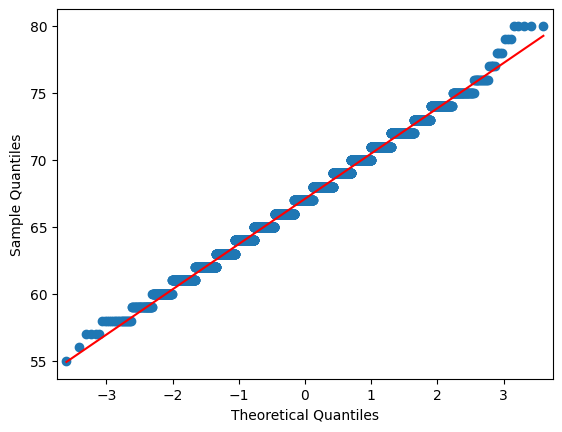

In [43]:
qqplot_data_target = qqplot(df_A[target], line='s').gca().lines

In [44]:
fig = go.Figure()

fig.add_trace({
    'type': 'scatter',
    'x': qqplot_data_target[0].get_xdata(),
    'y': qqplot_data_target[0].get_ydata(),
    'mode': 'markers',
})

fig.add_trace({
    'type': 'scatter',
    'x': qqplot_data_target[1].get_xdata(),
    'y': qqplot_data_target[1].get_ydata(),
    'mode': 'lines',
})


fig['layout'].update({
    'title': 'QQ Plot of Exam Score Group A',
    'xaxis': {
        'title': 'Theoretical Quantities',
        'zeroline': False
    },
    'yaxis': {
        'title': 'Sample Quantities'
    },
    'showlegend': False,
    'width': 800,
    'height': 700,
})

fig.show()

In [45]:
for i, col in enumerate(numerical_columns):
    fig = px.histogram(
        df_A,
        x=col,
        marginal='box',
        title=f"Group A {col} Distribution",
        text_auto=True,
        color_discrete_sequence=[theme_colors[(i + 1) % len(theme_colors)]]
    )
    fig.update_layout(bargap=0.2)
    fig.show()

The split has had **no significant impact** on the distribution of numerical features. However, the target variable is now **closer to a normal distribution** and can be considered as such.  

Next, we will explore the relationship between the target and numerical features using the **Pearson Correlation Coefficient** to assess linear relationships. It's important to note that this correlation assumes both variables are normally distributed. However, since our sample size is Large, the test remains **robust to non-normality** and can still provide meaningful insights.

In [46]:
pearson_corr = df_A[numerical_columns + [target]].corr(method='pearson')

fig = go.Figure(data=go.Heatmap(
    z=pearson_corr.values,
    x=pearson_corr.columns,
    y=pearson_corr.columns,
    colorscale='Blues',
    colorbar=dict(title='Pearson Correlation Coefficient'),
    text=pearson_corr.values,
    texttemplate="%{text:.2f}",
))
fig.update_layout(
    title='Pearson Correlation Matrix of Numerical Features of Group A',
)

fig.show()

In [47]:
stats.pearsonr(df_A['Attendance'], df_A[target])

PearsonRResult(statistic=0.6704343503825366, pvalue=0.0)

In [48]:
stats.pearsonr(df_A['Hours_Studied'], df_A[target])

PearsonRResult(statistic=0.5188692649724885, pvalue=0.0)

Attendance and Hours_Studied seem to exhibit a linear relationship with Exam_Score. Let's test this further using a t-test, scatter plots, and trying to fit a simple linear regression.

Null Hypothesis (H₀): There is no linear relationship between the two variables (r=0).
Alternative Hypothesis (H₁): There is a linear relationship (𝑟≠0)

In [49]:
# Sample size
n = len(df_A[target])

# Correlation coefficients
r_attendance = 0.6704
r_hours = 0.5188

# T-test for Attendance
t_attendance = r_attendance * np.sqrt((n - 2) / (1 - r_attendance**2))
p_attendance = 2 * stats.t.sf(np.abs(t_attendance), df=n - 2)  # Two-tailed p-value

# T-test for Hours_Studied
t_hours = r_hours * np.sqrt((n - 2) / (1 - r_hours**2))
p_hours = 2 * stats.t.sf(np.abs(t_hours), df=n - 2)  # Two-tailed p-value

# Print results
print(f"T-statistic (Attendance): {t_attendance:.4f}, P-value: {p_attendance:.4e}")
print(f"T-statistic (Hours_Studied): {t_hours:.4f}, P-value: {p_hours:.4e}")

# Interpretation of the null hypothesis
if p_attendance < 0.05:
    print("For Attendance: Reject the null hypothesis (significant correlation).")
else:
    print("For Attendance: Fail to reject the null hypothesis (no significant correlation).")

if p_hours < 0.05:
    print("For Hours_Studied: Reject the null hypothesis (significant correlation).")
else:
    print("For Hours_Studied: Fail to reject the null hypothesis (no significant correlation).")

T-statistic (Attendance): 71.9010, P-value: 0.0000e+00
T-statistic (Hours_Studied): 48.2938, P-value: 0.0000e+00
For Attendance: Reject the null hypothesis (significant correlation).
For Hours_Studied: Reject the null hypothesis (significant correlation).


Let's look at the t-statistic quantile and check there as well if we can reject the null hypothesis.

In [50]:
stats.t.ppf(q=0.025, df=n-1)

-1.9603385846197479

In [51]:
stats.t.ppf(q=0.975, df=n-1)

1.9603385846197474

Both t values are far outside the range to consider the t-static as pointing to accepting the alternative hypothesis. Both the t-test and the p-value of the Pearson coefficient have proved that the correlation coefficient is statistically significant and that there is a linear relationship between the variables

In [52]:
fig1 = px.scatter(df_A, x='Attendance', y='Exam_Score',
                  title='Regression: Exam_Score vs Attendance',
                  trendline="ols")
fig2 = px.scatter(df_A, x='Hours_Studied', y='Exam_Score',
                  title='Regression: Exam_Score vs Hours_Studied',
                  trendline="ols")
fig1.show()
fig2.show()

An Ordinary Least Squares Regression Line has been fitted on each scatter plot to help visualize how a simple linear regression line looks like on the data.

In [53]:
import statsmodels.api as sm

# Attendance Model
X_attendance = sm.add_constant(df_A['Attendance'])  # Add intercept
model_attendance = sm.OLS(df_A['Exam_Score'], X_attendance).fit()
print(model_attendance.summary())

                            OLS Regression Results                            
Dep. Variable:             Exam_Score   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     5171.
Date:                Mon, 24 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:16:44   Log-Likelihood:                -14811.
No. Observations:                6335   AIC:                         2.963e+04
Df Residuals:                    6333   BIC:                         2.964e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.4022      0.220    233.159      0.0

### **OLS Regression Results: Exam_Score vs Attendance**  

#### **Key Metrics:**  

- **R-squared: 0.449** – About **44.9%** of the variation in **Exam_Score** is explained by **Attendance**, indicating a **moderate fit**. The remaining **55.1%** is influenced by other factors not included in the model.  
- **Adjusted R-squared: 0.449** – Since there is only one predictor, this value is **nearly identical** to the R-squared value.  

#### **Model Significance:**  
- **F-statistic: 5171** – This high value suggests the model is significantly better at predicting **Exam_Score** than simply using its mean.  
- **Prob (F-statistic): 0.000** – Since this value is **less than 0.05**, the model is statistically significant.  

#### **Coefficients:**  
- **Intercept (const): 51.4022** – The expected **Exam_Score** when **Attendance** is **0**.  
- **Attendance coefficient: 0.1961** – For every **1-unit increase** in **Attendance**, the predicted **Exam_Score** increases by **0.1961**, confirming a **positive linear relationship**.  

#### **Statistical Tests:**  
- **Standard error (Attendance): 0.003** – Indicates the precision of the coefficient estimate.  
- **t-statistic (Attendance): 71.908** – A **high value**, indicating that **Attendance** is a significant predictor.  
- **P-value (Attendance): 0.000** – Since it is **less than 0.05**, **Attendance** is statistically significant.  
- **Confidence Interval (Attendance): [0.191, 0.201]** – The true coefficient is likely within this range, and since **0 is not included**, the effect is significant.  

#### **Assumption Checks:**  
- **Durbin-Watson: 2.049** – Suggests **no autocorrelation** in residuals.  
- **Omnibus & Jarque-Bera Tests** – Indicate that residuals **do not follow a perfect normal distribution**, which might affect some model assumptions.  

#### **Conclusion:**  
- **Attendance** is a **statistically significant** predictor of **Exam_Score**, with a **positive linear relationship**.  
- The model explains approximately **45%** of the variation in exam scores.  
- Despite the residuals not being perfectly normal, the **F-statistic and p-value** confirm that the model is **statistically valid**.

In [54]:
# Hours_Studied Model
X_hours = sm.add_constant(df_A['Hours_Studied'])  # Add intercept
model_hours = sm.OLS(df_A['Exam_Score'], X_hours).fit()
print(model_hours.summary())

                            OLS Regression Results                            
Dep. Variable:             Exam_Score   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     2333.
Date:                Mon, 24 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:19:04   Log-Likelihood:                -15708.
No. Observations:                6335   AIC:                         3.142e+04
Df Residuals:                    6333   BIC:                         3.143e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            61.2354      0.127    483.811

### **OLS Regression Results: Exam_Score vs Hours_Studied**

#### **Key Metrics:**

- **R-squared: 0.269** – About **26.9%** of the variation in **Exam_Score** is explained by **Hours_Studied**, indicating a **modest fit**. The remaining **73.1%** is influenced by other factors not included in the model.
- **Adjusted R-squared: 0.269** – Since there is only one predictor, this value is **almost identical** to the R-squared value.

#### **Model Significance:**
- **F-statistic: 2333** – A **high value**, suggesting that the model significantly predicts **Exam_Score** compared to just using the mean.
- **Prob (F-statistic): 0.000** – Since this is **less than 0.05**, the model is statistically significant.

#### **Coefficients:**
- **Intercept (const): 61.2354** – The expected **Exam_Score** when **Hours_Studied** is **0**.
- **Hours_Studied coefficient: 0.2931** – For each **1-unit increase** in **Hours_Studied**, the predicted **Exam_Score** increases by **0.2931**, confirming a **positive linear relationship**.

#### **Statistical Tests:**
- **Standard error (Hours_Studied): 0.006** – Indicates the precision of the coefficient estimate.
- **t-statistic (Hours_Studied): 48.303** – A **high value**, showing that **Hours_Studied** is a significant predictor.
- **P-value (Hours_Studied): 0.000** – Since it's **less than 0.05**, **Hours_Studied** is statistically significant.
- **Confidence Interval (Hours_Studied): [0.281, 0.305]** – We are 95% confident the true coefficient lies within this range, and since **0 is not within this interval**, the effect is significant.

#### **Assumption Checks:**
- **Durbin-Watson: 1.977** – Suggests **no autocorrelation** in the residuals.
- **Omnibus & Jarque-Bera Tests** – Indicate that residuals **are not perfectly normal**, which could influence some model assumptions.

#### **Conclusion:**
- **Hours_Studied** is a **significant predictor** of **Exam_Score**, with a **positive linear relationship**.
- The model explains about **27%** of the variance in exam Scores.
- Both the **F-statistic and p-value** confirm the model is **statistically significant**.

In [55]:
import plotly.graph_objects as go

# For the Attendance model
residuals_attendance = df_A['Exam_Score'] - model_attendance.predict(X_attendance)

# For the Hours_Studied model
residuals_hours = df_A['Exam_Score'] - model_hours.predict(X_hours)

# Create residual plot for Attendance
fig_attendance = go.Figure()

fig_attendance.add_trace(go.Scatter(
    x=model_attendance.predict(X_attendance),
    y=residuals_attendance,
    mode='markers',
    name='Residuals for Attendance',
))

# Add a horizontal line at 0 for reference
fig_attendance.add_trace(go.Scatter(
    x=[min(model_attendance.predict(X_attendance)), max(model_attendance.predict(X_attendance))],
    y=[0, 0],
    mode='lines',
    name='Zero Line',
    line=dict(color='red', dash='dash')
))

fig_attendance.update_layout(
    title='Residuals for Exam_Score vs Attendance',
    xaxis_title='Predicted Exam_Score',
    yaxis_title='Residuals',
)

# Create residual plot for Hours_Studied
fig_hours = go.Figure()

fig_hours.add_trace(go.Scatter(
    x=model_hours.predict(X_hours),
    y=residuals_hours,
    mode='markers',
    name='Residuals for Hours_Studied',
))

# Add a horizontal line at 0 for reference
fig_hours.add_trace(go.Scatter(
    x=[min(model_hours.predict(X_hours)), max(model_hours.predict(X_hours))],
    y=[0, 0],
    mode='lines',
    name='Zero Line',
    line=dict(color='red', dash='dash')
))

fig_hours.update_layout(
    title='Residuals for Exam_Score vs Hours_Studied',
    xaxis_title='Predicted Exam_Score',
    yaxis_title='Residuals',
)

# Show both plots
fig_attendance.show()
fig_hours.show()

In [56]:
residuals_attendance = df_A['Exam_Score'] - model_attendance.predict(X_attendance)

# For the Hours_Studied model
residuals_hours = df_A['Exam_Score'] - model_hours.predict(X_hours)

# Create a histogram of residuals for Attendance
fig_attendance_dist = px.histogram(
    residuals_attendance,
    nbins=50,
    title='Distribution of Residuals for Exam_Score vs Attendance',
    labels={'value': 'Residuals'},
)

# Create a histogram of residuals for Hours_Studied
fig_hours_dist = px.histogram(
    residuals_hours,
    nbins=50,
    title='Distribution of Residuals for Exam_Score vs Hours_Studied',
    labels={'value': 'Residuals'},
)

# Show both plots
fig_attendance_dist.show()
fig_hours_dist.show()

While the residuals do not have a perfect normal distribution, they can be considered close to one, and therefore assumed as random

# **Top Performing Students Numerical Distribution of group B**
The dataset for this pool is too small and too prone to outliers and false data, that no statistical analysis is worth being performed. However, we can still look at some distributions.

In [57]:
fig = px.histogram(df_B, x=target, marginal='box', title=f"Group B Distribution of Target Column (Exam Score)", text_auto=True)
fig.update_layout(bargap=0.2)
fig.show()

In [58]:
for i, col in enumerate(numerical_columns):
    fig = px.histogram(
        df_B,
        x=col,
        marginal='box',
        title=f"Group B {col} Distribution",
        text_auto=True,
        color_discrete_sequence=[theme_colors[(i + 1) % len(theme_colors)]]
    )
    fig.update_layout(bargap=0.2)
    fig.show()

# Group A & B Categorical Features Comparison
Let's examine the categorical features to understand their relationship with the target variable and how the two groups (Group A and Group B) compare with each other

In [59]:
def create_stacked_bar_plot(categorical_feature):
    grouped_data = df_cleaned.groupby([categorical_feature, 'Exam_Score']).size().reset_index(name='count')

    # Calculate total count for each target (Exam_Score) to normalize proportions
    total_count = grouped_data.groupby('Exam_Score')['count'].transform('sum')
    grouped_data['proportion'] = grouped_data['count'] / total_count

    traces = []
    for category in grouped_data[categorical_feature].unique():
        category_data = grouped_data[grouped_data[categorical_feature] == category]
        traces.append(go.Bar(
            x=category_data['Exam_Score'],
            y=category_data['proportion'],
            name=str(category),
        ))

    fig = go.Figure(data=traces)

    # Add a vertical dotted line at Exam_Score = 80
    fig.add_shape(
        type="line",
        x0=80,
        x1=80,
        y0=0,
        y1=1,
        line=dict(
            color="black",
            width=3,
            dash="dot"  # Dotted line
        ),
    )


    # Layout of the plot
    fig.update_layout(
        title=f'Distribution of Exam_Score by {categorical_feature}',
        xaxis_title='Exam_Score',
        yaxis_title='Proportion',
        barmode='stack',
    )

    fig.show()

for feature in categorical_columns:
    create_stacked_bar_plot(feature)

<ipython-input-59-0318b0636f89>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<ipython-input-59-0318b0636f89>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<ipython-input-59-0318b0636f89>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<ipython-input-59-0318b0636f89>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<ipython-input-59-0318b0636f89>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<ipython-input-59-0318b0636f89>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<ipython-input-59-0318b0636f89>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<ipython-input-59-0318b0636f89>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<ipython-input-59-0318b0636f89>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<ipython-input-59-0318b0636f89>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<ipython-input-59-0318b0636f89>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<ipython-input-59-0318b0636f89>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<ipython-input-59-0318b0636f89>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<ipython-input-59-0318b0636f89>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



We observe that the subcategories of these features are **not proportionate** in terms of sample size.  

The **majority group** tends to show a stronger inclination toward trends and patterns, such as **linearity**, compared to the **elite group** of higher scores. However, it's important to note that **Group B (elite)** is significantly smaller than **Group A**, and there may be cases of **cheating** within this smaller group. While cheaters may not have a significant impact on the larger **Group A**, they could heavily influence the results in **Group B**, leading to skewed findings.  

#### **Conclusions:**
- Factors such as **access to resources**, participation in **extracurricular activities**, engagement in **physical activities**, and **motivation levels** are positively associated with higher exam scores in the **average student population**.
- **Parental involvement**, **family income**, and **parental education level** also significantly influence academic performance.  
- These findings suggest that the **educational system** may not provide sufficient support to **students from disadvantaged backgrounds**, contributing to disparities in academic outcomes.